In [131]:
import pandas as pd
import numpy as np
import re

# 1.1 Load and Inspect the Dataset
# Load the dataset
df = pd.read_csv("Building_Energy_Benchmarking.csv")

# Display shape, column names, and data types
print("Shape of the dataset:", df.shape)
print("Column names:", df.columns.tolist())
print("Data types:\n", df.dtypes)

# Identify and list the number of missing values in each column
print("Missing values:\n", df.isnull().sum())

# 1.2 Handling Missing Data
# Drop columns with more than 40% missing values
threshold = 0.4 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Fill missing values for numerical columns with the median
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill missing values for categorical columns with the mode
categorical_cols = df.select_dtypes(include=[object]).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# 1.3 Extracting and Cleaning Data Using Regex
# Extract numeric values from text-based numeric columns
def extract_numeric(text):
    if pd.isna(text):
        return np.nan
    numbers = re.findall(r'\d+\.?\d*', str(text))
    return float(numbers[0]) if numbers else np.nan

# Apply to relevant columns (e.g., Property GFA, Energy Use, Emissions)
df['Property GFA - Self-Reported (m²)'] = pd.to_numeric(df['Property GFA - Self-Reported (m²)'], errors='coerce')
df['Electricity Use - Grid Purchase (kWh)'] = pd.to_numeric(df['Electricity Use - Grid Purchase (kWh)'], errors='coerce')
df['Natural Gas Use (GJ)'] = pd.to_numeric(df['Natural Gas Use (GJ)'], errors='coerce')
df['Total GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df['Total GHG Emissions (Metric Tons CO2e)'], errors='coerce')
df['Site Energy Use (GJ)'] = pd.to_numeric(df['Site Energy Use (GJ)'], errors='coerce')
df['Site EUI (GJ/m²)'] = pd.to_numeric(df['Site EUI (GJ/m²)'], errors='coerce')

# Standardize Postal Codes to follow the Canadian format (A1A 1A1)
def standardize_postal_code(postal_code):
    if pd.isna(postal_code):
        return np.nan
    postal_code = re.sub(r'[^A-Za-z0-9]', '', postal_code)  # Remove non-alphanumeric characters
    if len(postal_code) == 6:
        return f"{postal_code[0:3]} {postal_code[3:6]}".upper()
    return np.nan

df['Postal Code'] = df['Postal Code'].apply(standardize_postal_code)

# Clean and extract meaningful text from Property Names and Addresses
def clean_text(text):
    if pd.isna(text):
        return np.nan
    return re.sub(r'[^A-Za-z0-9\s]', '', str(text)).strip()

df['Property Name'] = df['Property Name'].apply(clean_text)
df['Address 1'] = df['Address 1'].apply(clean_text)

# Ensure extracted values are properly converted to numerical types for analysis
df['Property GFA - Self-Reported (m²)'] = pd.to_numeric(df['Property GFA - Self-Reported (m²)'], errors='coerce')
df['Electricity Use - Grid Purchase (kWh)'] = pd.to_numeric(df['Electricity Use - Grid Purchase (kWh)'], errors='coerce')
df['Total GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df['Total GHG Emissions (Metric Tons CO2e)'], errors='coerce')
df['Site EUI (GJ/m²)'] = pd.to_numeric(df['Site EUI (GJ/m²)'], errors='coerce')
# Display cleaned dataset
print(df.head())

Shape of the dataset: (494, 31)
Column names: ['Property Id', 'Property Name', 'Address 1', 'City', 'Postal Code', 'Province', 'Primary Property Type - Self Selected', 'Number of Buildings', 'Year Built', 'Property GFA - Self-Reported (m²)', 'ENERGY STAR Score', 'Site Energy Use (GJ)', 'Weather Normalized Site Energy Use (GJ)', 'Site EUI (GJ/m²)', 'Weather Normalized Site EUI (GJ/m²)', 'Source Energy Use (GJ)', 'Weather Normalized Source Energy Use (GJ)', 'Source EUI (GJ/m²)', 'Weather Normalized Source EUI (GJ/m²)', 'Total GHG Emissions (Metric Tons CO2e)', 'Total GHG Emissions Intensity (kgCO2e/m²)', 'Direct GHG Emissions (Metric Tons CO2e)', 'Direct GHG Emissions Intensity (kgCO2e/m²)', 'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (GJ)', 'District Hot Water Use (GJ)', 'Electricity Use – Generated from Onsite Renewable Systems (kWh)', 'Green Power - Onsite and Offsite (kWh)', 'Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)', 'Year Ending', 'Unique 

In [132]:
# 2.1 Statistical Summary
# Generate summary statistics for numerical features
print("Summary statistics for numerical features:\n", df[numerical_cols].describe())

# Identify and explain key observations (e.g., outliers, mean vs. median differences)
some_threshold = 1000
for col in df.select_dtypes(include=[np.number]).columns:
    mean_val = df[col].mean()
    median_val = df[col].median()
    if abs(mean_val - median_val) > some_threshold:  
        print(f"There is a significant difference（{abs(mean_val - median_val)} ）between  mean({mean_val}) and median({median_val}) of {col}, which may indicate a skewed distribution.")

# 2.2 Aggregations
# Compute the average Energy Use Intensity (EUI) by Property Type
average_eui_by_type = df.groupby('Primary Property Type - Self Selected')['Site EUI (GJ/m²)'].mean()
print("Average EUI by Property Type:\n", average_eui_by_type)

# Compute the total Greenhouse Gas (GHG) emissions by year
total_ghg_by_year = df.groupby('Year Ending')['Total GHG Emissions (Metric Tons CO2e)'].sum()
print("Total GHG Emissions by Year:\n", total_ghg_by_year)

# Identify the top 5 properties with the highest total energy consumption
top_5_energy_consumers = df.nlargest(5, 'Electricity Use - Grid Purchase (kWh)')
print("Top 5 properties with the highest energy consumption:\n", top_5_energy_consumers[['Property Name', 'Electricity Use - Grid Purchase (kWh)']])

# 2.3 Detecting Outliers Using Regex and IQR
# Use Regex to identify values that do not conform to expected numeric formats
def is_valid_numeric(value):
    return bool(re.match(r'^\d+\.?\d*$', str(value)))

def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

def detect_outliers_in_all_columns(df):
    outliers_dict = {}
    for column in df.select_dtypes(include=['number']).columns:
        outliers = detect_outliers(df[column]) 
        if not outliers.empty:
            outliers_dict[column] = outliers

    return outliers_dict

outliers_in_all_columns = detect_outliers_in_all_columns(df)

for column, outliers in outliers_in_all_columns.items():
    print(f"Outliers in column '{column}':")
    print(outliers)


# Replace outliers with the median value for that property type
df['Total GHG Emissions (Metric Tons CO2e)'] = np.where(
    (df['Total GHG Emissions (Metric Tons CO2e)'] < lower_bound) | (df['Total GHG Emissions (Metric Tons CO2e)'] > upper_bound),
    df.groupby('Primary Property Type - Self Selected')['Total GHG Emissions (Metric Tons CO2e)'].transform('median'),
    df['Total GHG Emissions (Metric Tons CO2e)']
)

Summary statistics for numerical features:
         Property Id  Number of Buildings   Year Built  Site EUI (GJ/m²)  \
count  4.940000e+02           494.000000   494.000000        494.000000   
mean   1.308877e+07             1.060729  1980.091093          1.774798   
std    5.659556e+06             0.278281    25.159568          1.306700   
min    6.169481e+06             1.000000  1896.000000          0.060000   
25%    9.563763e+06             1.000000  1970.000000          0.990000   
50%    9.997794e+06             1.000000  1978.000000          1.290000   
75%    2.198860e+07             1.000000  1996.000000          2.065000   
max    2.198863e+07             3.000000  2018.000000          8.430000   

       Weather Normalized Site EUI (GJ/m²)  Source EUI (GJ/m²)  \
count                           494.000000          494.000000   
mean                              1.810324            2.282753   
std                               1.331529            1.597846   
min             

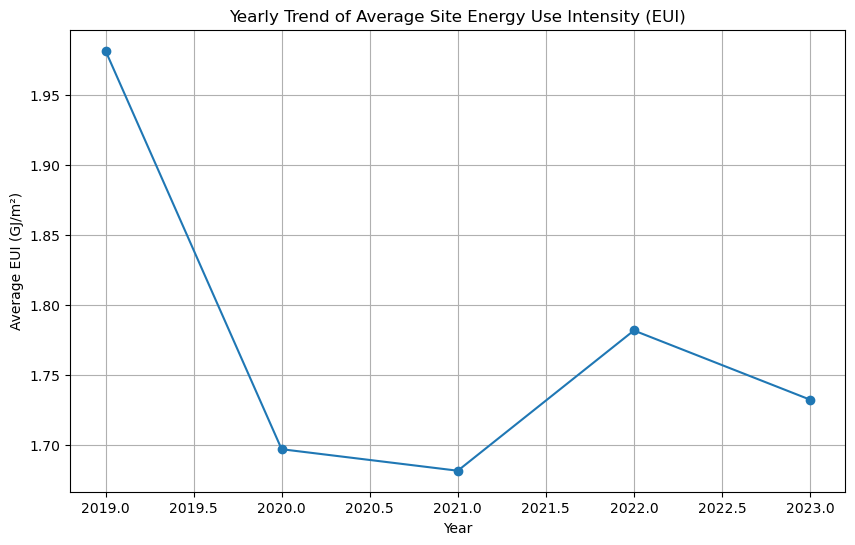

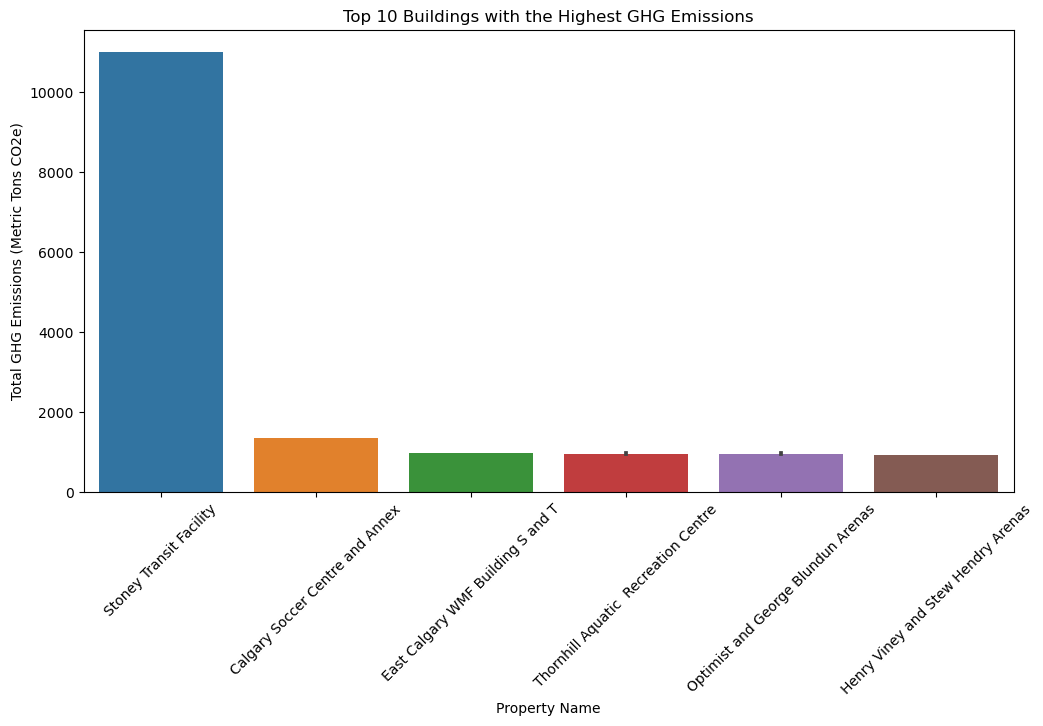

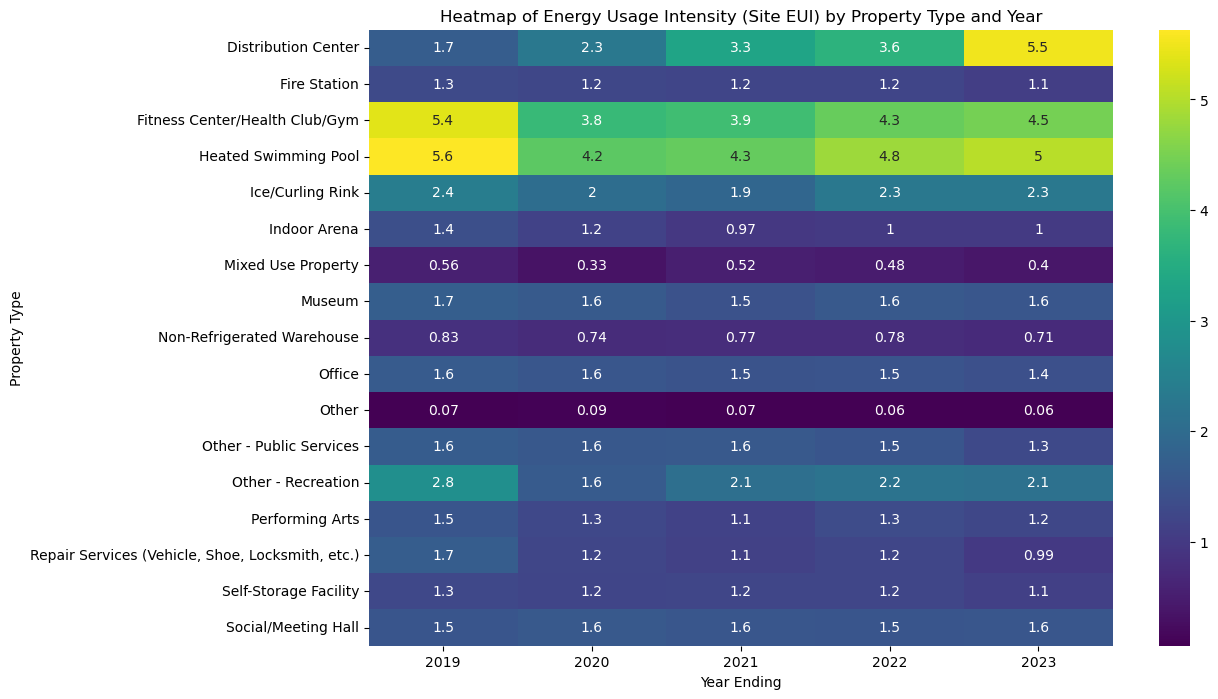

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3.1 Time-Series Visualization
# Plot the yearly trend of average Site Energy Use Intensity (EUI)
average_eui_by_year = df.groupby('Year Ending')['Site EUI (GJ/m²)'].mean()
plt.figure(figsize=(10, 6))
plt.plot(average_eui_by_year.index, average_eui_by_year.values, marker='o')
plt.title("Yearly Trend of Average Site Energy Use Intensity (EUI)")
plt.xlabel("Year")
plt.ylabel("Average EUI (GJ/m²)")
plt.grid()
plt.show()

# 3.2 Comparative Bar Charts
# Create a bar chart showing the top 10 buildings with the highest GHG emissions
top_10_ghg_emitters = df.nlargest(10, 'Total GHG Emissions (Metric Tons CO2e)')
plt.figure(figsize=(12, 6))
sns.barplot(x='Property Name', y='Total GHG Emissions (Metric Tons CO2e)', data=top_10_ghg_emitters)
plt.title("Top 10 Buildings with the Highest GHG Emissions")
plt.xlabel("Property Name")
plt.ylabel("Total GHG Emissions (Metric Tons CO2e)")
plt.xticks(rotation=45)
plt.show()

# 3.3 Heatmap Visualization
# Create a heatmap of energy usage intensity (Site EUI (GJ/m²)) across different property types
heatmap_data = df.pivot_table(index='Primary Property Type - Self Selected', columns='Year Ending', values='Site EUI (GJ/m²)', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis')
plt.title("Heatmap of Energy Usage Intensity (Site EUI) by Property Type and Year")
plt.xlabel("Year Ending")
plt.ylabel("Property Type")
plt.show()

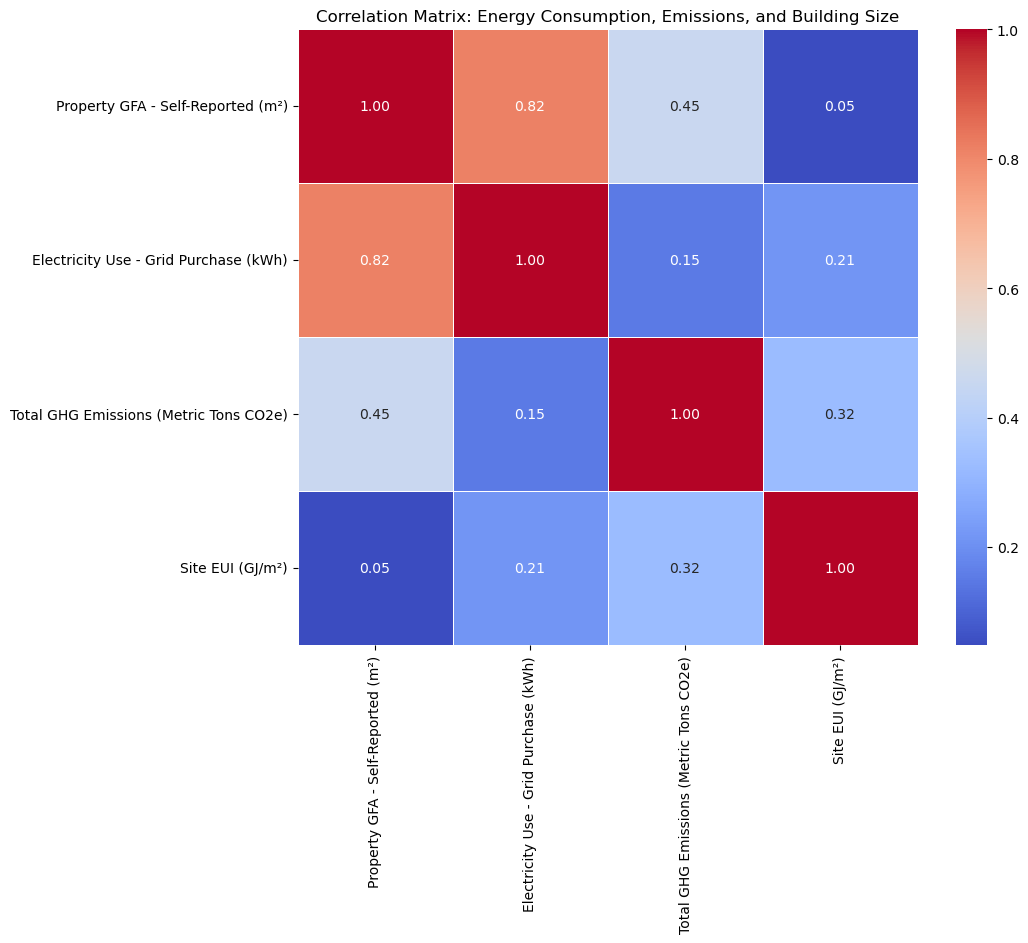

Correlation Matrix:
                                         Property GFA - Self-Reported (m²)  \
Property GFA - Self-Reported (m²)                                1.000000   
Electricity Use - Grid Purchase (kWh)                            0.817144   
Total GHG Emissions (Metric Tons CO2e)                           0.454995   
Site EUI (GJ/m²)                                                 0.047851   

                                        Electricity Use - Grid Purchase (kWh)  \
Property GFA - Self-Reported (m²)                                    0.817144   
Electricity Use - Grid Purchase (kWh)                                1.000000   
Total GHG Emissions (Metric Tons CO2e)                               0.149521   
Site EUI (GJ/m²)                                                     0.214272   

                                        Total GHG Emissions (Metric Tons CO2e)  \
Property GFA - Self-Reported (m²)                                     0.454995   
Electricity Use - Grid 

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation analysis
correlation_columns = [
    'Property GFA - Self-Reported (m²)',  # Building size
    'Electricity Use - Grid Purchase (kWh)',  # Energy consumption
    'Total GHG Emissions (Metric Tons CO2e)',  # Emissions
    'Site EUI (GJ/m²)'  # Energy Use Intensity
]

# Compute the correlation matrix
correlation_matrix = df[correlation_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Energy Consumption, Emissions, and Building Size")
plt.show()

# Identify strong correlations and explain their implications
print("Correlation Matrix:\n", correlation_matrix)

# Explanation of strong correlations
strong_correlations = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]
print("Strong Correlations:\n", strong_correlations)



In [135]:
from scipy.stats import ttest_ind
# Compare the average Energy Star Score between Offices and Fire Station
# Filter data for the two property types
office_data = df[df['Primary Property Type - Self Selected'] == 'Office']['Site EUI (GJ/m²)']
residential_data = df[df['Primary Property Type - Self Selected'] == 'Fire Station']['Site EUI (GJ/m²)']

# Conduct a t-test
t_stat, p_value = ttest_ind(office_data.dropna(), residential_data.dropna())

# Interpret the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The difference in average Site EUI between Offices and Residential buildings is statistically significant.")
else:
    print("The difference in average Site EUI between Offices and Residential buildings is not statistically significant.")

T-statistic: 3.808114250407815, P-value: 0.00017126218412442606
The difference in average Site EUI between Offices and Residential buildings is statistically significant.
